Импортирование библиотек

In [3]:
import os
import pandas as pd
import psycopg2
import warnings

from psycopg2.extras import RealDictCursor
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns


warnings.filterwarnings('ignore')
load_dotenv('../.env')

True

Загрузка данных

In [4]:
db_config = {
    'dbname': os.getenv('POSTGRES_DB', 'bank_system'),
    'user': os.getenv('POSTGRES_USER', 'postgres'),
    'password': os.getenv('POSTGRES_PASSWORD', 'postgres'),
    'host': os.getenv('POSTGRES_HOST', 'localhost'),
    'port': os.getenv('POSTGRES_PORT', '5432')
}

def get_connection():
    try:
        conn = psycopg2.connect(
            dbname=db_config['dbname'],
            user=db_config['user'],
            password=db_config['password'],
            host=db_config['host'],
            port=db_config['port']
        )
        print("Успешное подключение к базе данных!")
        return conn
    except Exception as e:
        print(f"Ошибка подключения: {e}")
        return None

def load_table_with_psycopg2(table_name):
    conn = None
    try:
        conn = get_connection()
        if not conn:
            return None
            
        with conn.cursor(cursor_factory=RealDictCursor) as cur:
            cur.execute(f"SELECT * FROM {table_name}")
            rows = cur.fetchall()

            df = pd.DataFrame(rows)
            print(f"Таблица '{table_name}': {len(df)} строк, {len(df.columns)} столбцов")
            return df
            
    except Exception as e:
        print(f"Ошибка загрузки таблицы '{table_name}': {e}")
        return None
    finally:
        if conn:
            conn.close()


In [6]:
# Список всех таблиц в базе данных
tables = [
    'users',
    'achievements',
    'user_achievements',
    'payment_system',
    'bank_accounts',
    'saving_accounts',
    'user_bank_accounts',
    'transaction_type',
    'transactions',
    'bank_accounts_invitations',
    'scheduled_transfers'
]

# Словарь для хранения всех DataFrame
dataframes = {}

for table in tables:
    df = load_table_with_psycopg2(table)
    if df is not None:
        dataframes[table] = df


print("\nОБЗОР ЗАГРУЖЕННЫХ ТАБЛИЦ")

for table_name, df in dataframes.items():
    print(f"\n {table_name.upper()}:")
    print(f"   Размер: {df.shape[0]} строк × {df.shape[1]} столбцов")
    print(f"   Столбцы: {', '.join(df.columns.tolist())}")
    
    if not df.empty:
        print(f"   Первые значения:")
        for col in df.columns[:3]:
            sample_values = df[col].head(4).tolist()
            print(f"     {col}: {sample_values}")


Успешное подключение к базе данных!
Таблица 'users': 324 строк, 7 столбцов
Успешное подключение к базе данных!
Таблица 'achievements': 4 строк, 4 столбцов
Успешное подключение к базе данных!
Таблица 'user_achievements': 216 строк, 3 столбцов
Успешное подключение к базе данных!
Таблица 'payment_system': 4 строк, 3 столбцов
Успешное подключение к базе данных!
Таблица 'bank_accounts': 200 строк, 8 столбцов
Успешное подключение к базе данных!
Таблица 'saving_accounts': 40 строк, 7 столбцов
Успешное подключение к базе данных!
Таблица 'user_bank_accounts': 200 строк, 3 столбцов
Успешное подключение к базе данных!
Таблица 'transaction_type': 4 строк, 2 столбцов
Успешное подключение к базе данных!
Таблица 'transactions': 2616 строк, 9 столбцов
Успешное подключение к базе данных!
Таблица 'bank_accounts_invitations': 0 строк, 0 столбцов
Успешное подключение к базе данных!
Таблица 'scheduled_transfers': 84 строк, 10 столбцов

ОБЗОР ЗАГРУЖЕННЫХ ТАБЛИЦ

 USERS:
   Размер: 324 строк × 7 столбцов
   

Визуализация данных

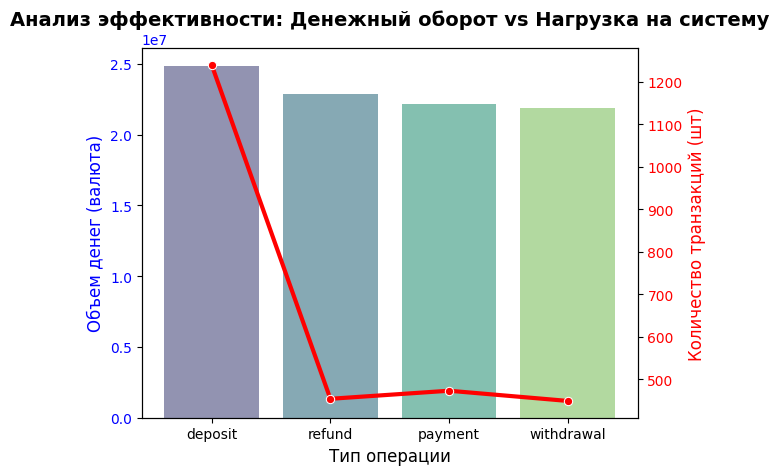


 СТАТИСТИКА ТРАНЗАКЦИЙ
         name          sum  count
0     deposit  24864378.51   1240
2      refund  22893091.18    454
1     payment  22187753.44    473
3  withdrawal  21855556.54    449


In [7]:
df_trans = dataframes['transactions'].merge(
    dataframes['transaction_type'], 
    left_on='type_id', 
    right_on='type_id', 
    how='left'
)

tx_stats = df_trans.groupby('name')['amount'].agg(['sum', 'count']).reset_index()
tx_stats = tx_stats.sort_values(by='sum', ascending=False)

fig, ax1 = plt.subplots()

sns.barplot(x='name', y='sum', data=tx_stats, ax=ax1, alpha=0.6, palette='viridis', hue='name', legend=False)
ax1.set_ylabel('Объем денег (валюта)', fontsize=12, color='blue')
ax1.set_xlabel('Тип операции', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
sns.lineplot(x='name', y='count', data=tx_stats, ax=ax2, marker='o', color='red', linewidth=3)
ax2.set_ylabel('Количество транзакций (шт)', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Анализ эффективности: Денежный оборот vs Нагрузка на систему', fontsize=14, fontweight='bold')
plt.show()

print("\n СТАТИСТИКА ТРАНЗАКЦИЙ")
print(tx_stats)

**Вывод**: Как видно на графике, кол-во транзакций у операций "deposit" наибольшее, при этом поток (кол-во) денег сравним с другими типами операций.
Таким образом, банку критически важно брать комиссию за транзакцию с типом "deposit", иначе обслуживание этих операций может быть убыточным.

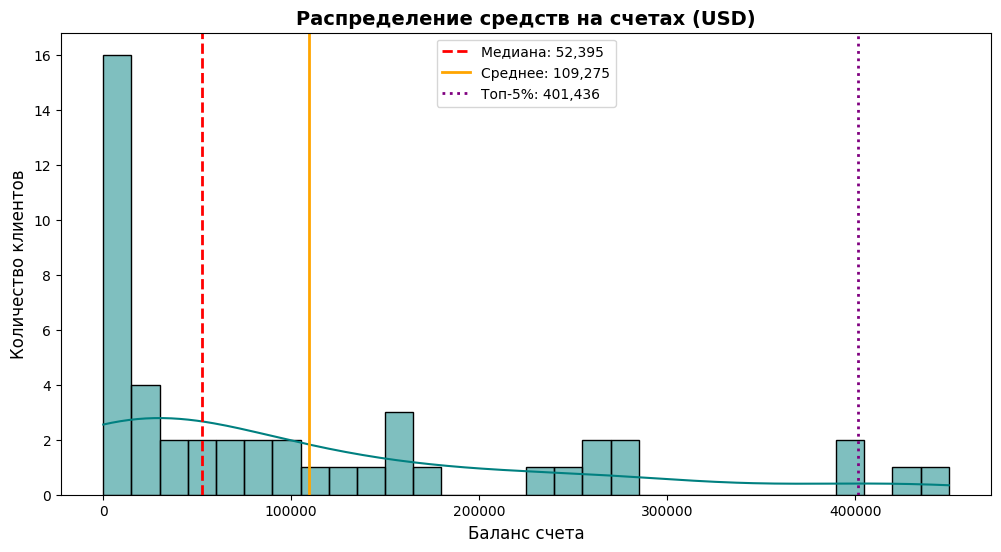

In [17]:
df_accounts = dataframes['bank_accounts']
target_currency = 'USD'

active_accounts = df_accounts[
    (df_accounts['status'] == 'active') & 
    (df_accounts['currency'] == target_currency)
].copy()

median_balance = active_accounts['balance'].median()
mean_balance = active_accounts['balance'].mean()
vip_threshold = active_accounts['balance'].astype(float).quantile(0.95)

plt.figure(figsize=(12, 6))

sns.histplot(active_accounts['balance'], bins=30, kde=True, color='teal')

plt.axvline(median_balance, color='red', linestyle='--', linewidth=2, label=f'Медиана: {median_balance:,.0f}')
plt.axvline(mean_balance, color='orange', linestyle='-', linewidth=2, label=f'Среднее: {mean_balance:,.0f}')
plt.axvline(vip_threshold, color='purple', linestyle=':', linewidth=2, label=f'Топ-5%: {vip_threshold:,.0f}')

plt.title(f'Распределение средств на счетах ({target_currency})', fontsize=14, fontweight='bold')
plt.xlabel('Баланс счета', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.legend()
plt.show()

**Вывод**: 
- Самый высокий столбец слева показывает "массового клиента", он в районе 0-100. Скорее всего, клиенты используют банк как "транзит" (получили зарплату -> сняли/перевели), не храня деньги. Таким клиентам нужно предлагать пользоваться накопительными счетами.
- Клиенты, находящиеся между Медианой и Топ-5% — это "cредний класс". Таким клиентам можно предлагать кредитные карты и ипотеки, так как у них есть деньги, но их недостаточно для крупных покупок без займа.